In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, csv, os
from sklearn import linear_model
from Utils import unet_segmenta, load_img, boxescount
import cv2

In [2]:
def multidim_cumsum(a):
	out = a[...,:].cumsum(-1)[...,:]
	for i in range(2,a.ndim+1):
		np.cumsum(out, axis=-i, out=out)
	return out

# Define mathematical function for curve fitting 
def func(x, y, a1, a2, a3, a4, a5, c): 
	return a1*x + a2*y + a3*x*y + a4*x*x + a5*y*y + c

def MF_DFA(dic_boxes, qmin = -5, qmax = 5, dq = 0.25):
    espectros = {}
    for side in dic_boxes.keys(): # Recorre cada lado
        # createFolder('2D_MFDFA_Pulmón_N'+str(num)+'_'+str(side)+'/')
        M=[];Q=np.arange( qmin-dq , qmax+2*dq , dq );NQ=len(Q);Mpre=[]  # Crea una lista con los valores de Q en función de qmin y qmax

        for j in range(NQ+1):
            M.append([]);Mpre.append([])

        for len_s in dic_boxes[side]: # Recorre cada tamano de caja
            # tx malla de la caja
            tx = np.array(range(int(len_s))); ty = tx; TX, TY = np.meshgrid(tx, ty) #es necesario para hacer el fit
            F=[]
            for box in range(dic_boxes[side][len_s].shape[0]): # Recorre cada caja de un determinado tamaño
                Sub_IM = dic_boxes[side][len_s][box] #renombro la caja a anlizar

                Sub_IM = Sub_IM - np.mean(Sub_IM) #restamos la media
                IM = multidim_cumsum(Sub_IM) #calculo la integracion de la superficie

                x1, y1, z1 = TX.flatten(), TY.flatten(), IM.flatten()
                x1y1, x1x1, y1y1 = x1*y1, x1*x1, y1*y1
                X_data = np.array([x1, y1, x1y1, x1x1, y1y1]).T  
                Y_data = z1

                reg = linear_model.LinearRegression().fit(X_data, Y_data)
                a1 = reg.coef_[0]; a2 = reg.coef_[1]; a3 = reg.coef_[2]; a4 = reg.coef_[3]; a5 = reg.coef_[4]; c = reg.intercept_

                ZZ = func(TX, TY, a1, a2, a3, a4, a5, c)
                
                F_matrix = IM-ZZ
                F.append(np.mean(F_matrix**2))

            M[0].append(np.log10(int(len_s)));Mpre[0].append(int(len_s))

            for j in range(NQ):
                if j == int(NQ/2):
                    M[j+1].append(np.log10( np.exp(0.5*np.mean(np.log(np.array(F)))) ))
                    Mpre[j+1].append(np.exp(0.5*np.mean(np.log(np.array(F)))) )
                else:
                    M[j+1].append(np.log10( np.mean(np.array(F)**(Q[j]/2.0))**(1.0/Q[j]) ))
                    Mpre[j+1].append(np.mean(np.array(F)**(Q[j]/2.0))**(1.0/Q[j]) )

        # F_qs = Mpre
        # np.savetxt('2D_MFDFA_Pulmón_N'+str(num)+'_'+str(side)+'/F_qs.txt',np.matrix(Mpre).transpose(),fmt='%s')

        MHT=[[],[],[]]; MHT[0]=Q
        for i in range(NQ):
            h=np.polyfit(M[0],M[i+1],1)[0]
            MHT[1].append(h);MHT[2].append(Q[i]*h-2)
        
        # h_tau_spectrum = MHT
        # np.savetxt('2D_MFDFA_Pulmón_N'+str(num)+'_'+str(side)+'/h_tau-spectrum.txt',np.matrix(MHT).transpose(),fmt='%s')

        Maf=[[],[]]
        for k in range(1,NQ-1):
            a=(MHT[2][k+1]-MHT[2][k-1])/(2*dq)
            Maf[0].append(a); Maf[1].append(MHT[0][k]*a-MHT[2][k])
        
        MF_spectrum = Maf
        espectros[side] = MF_spectrum
        # np.savetxt('2D_MFDFA_Pulmón_N'+str(num)+'_'+str(side)+'/MF-spectrum.txt',np.matrix(Maf).transpose(),fmt='%s')
    return espectros

In [3]:
def plt_espectros(espectros, rx, lungs,  limits = [1.7, 3.3, 0.3, 2.05]):
    plt.figure(figsize=[10,10])

    # Muestra radiografía
    plt.subplot(2,2,1)
    plt.title("RxT")
    plt.imshow(rx, cmap= 'gray')
    plt.axis("off")

    # Muestra pulmones
    plt.subplot(2,2,2)
    plt.title("Lungs")
    plt.imshow(lungs, cmap= 'gray')
    plt.axis("off")

    for i,key in enumerate(espectros):
        espectro = espectros[key]
        plt.subplot(2,2,i + 3)
        plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
        plt.title("Pulmnón " + key)

        plt.axis(limits)
        plt.xlabel("α", fontsize=18)
        plt.ylabel("f(α)", fontsize=18)

        plt.plot(espectro[0],espectro[1])
        plt.scatter(espectro[0],espectro[1],alpha = 0.4,s=20)


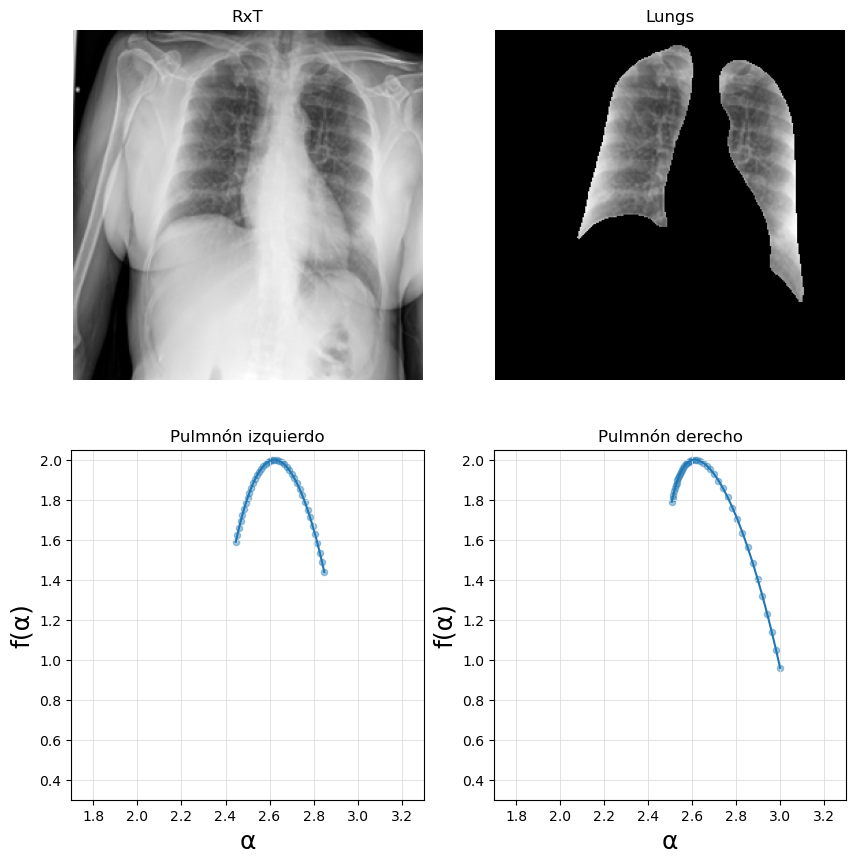

In [4]:
path_covid_origen = "Data_Source\COVID-QU-Ex dataset\Lung Segmentation Data\Lung Segmentation Data\Train\COVID-19\images"
model = unet_segmenta()
img_list = os.listdir(path_covid_origen)

# Lectura de la radiografía
image_path = os.path.join(path_covid_origen,img_list[np.random.randint(0,len(img_list))]) # Dirección de la imagen
rx = cv2.imread(image_path, 0) # Lectura de la imagen

# Ajuste de la imagen
image = load_img(rx) # Preparación de la imagen

# Segmentación de pulmones
mask = model.predict(image, verbose = 0) # Obtención de la mascara
lungs = np.array(image[0,:,:,0])*255 
lungs[mask[0,:,:,0]<0.5] = 0  # Imagen con información unicamente de los pulomnes

# Seccionamiento de información en cajas
boxes = boxescount(lungs=lungs)  
dic_boxes = boxes.dic_boxes() 

# Calculo de espectros
espectros = MF_DFA(dic_boxes)

plt_espectros(espectros, rx, lungs)